# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [2]:
from __future__ import print_function, division
%matplotlib inline
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from seaborn import heatmap

/afs/inf.ed.ac.uk/user/s16/s1669411/virtualenvs/iaml_env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [124]:
# Your code goes here
data_path_train = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
data_path_valid = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
train_A = pd.read_csv(data_path_train, delimiter = ',')
valid_A = pd.read_csv(data_path_valid, delimiter = ',')
print('Number of instances for train: {}, number of attributes for train: {}'.format(train_A.shape[0], train_A.shape[1]))
print('Number of instances for valid: {}, number of attributes for valid: {}'.format(valid_A.shape[0], valid_A.shape[1]))
train_A.info()
valid_A.info()

Number of instances for train: 2093, number of attributes for train: 520
Number of instances for valid: 1113, number of attributes for valid: 520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Columns: 520 entries, imgId to is_tvmonitor
dtypes: float64(495), int64(24), object(1)
memory usage: 8.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Columns: 520 entries, imgId to is_tvmonitor
dtypes: float64(494), int64(25), object(1)
memory usage: 4.4+ MB


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [125]:
# Your code goes here
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [126]:
list_name=train_A.columns.tolist()[1:501]

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [127]:
X_tr = train_A[list_name].values
X_val =valid_A[list_name].values
y_tr =train_A['is_person'].values
y_val =valid_A ['is_person'].values

print ("the dimensionalities for X_tr is :",X_tr.shape)
print ("the dimensionalities for X_val is :",X_val.shape)
print ("the dimensionalities for y_tr is :",y_tr.shape)
print ("the dimensionalities for y_val is :",y_val.shape)
print(X_val)

the dimensionalities for X_tr is : (2093L, 500L)
the dimensionalities for X_val is : (1113L, 500L)
the dimensionalities for y_tr is : (2093L,)
the dimensionalities for y_val is : (1113L,)
[[ 0.002  0.     0.003 ...,  0.004  0.006  0.008]
 [ 0.002  0.     0.004 ...,  0.001  0.001  0.003]
 [ 0.001  0.     0.005 ...,  0.001  0.001  0.004]
 ..., 
 [ 0.001  0.001  0.001 ...,  0.004  0.001  0.002]
 [ 0.003  0.     0.003 ...,  0.004  0.005  0.001]
 [ 0.     0.     0.007 ...,  0.     0.004  0.001]]


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

[<matplotlib.text.Text at 0x2d62f748>, <matplotlib.text.Text at 0x2563d400>]

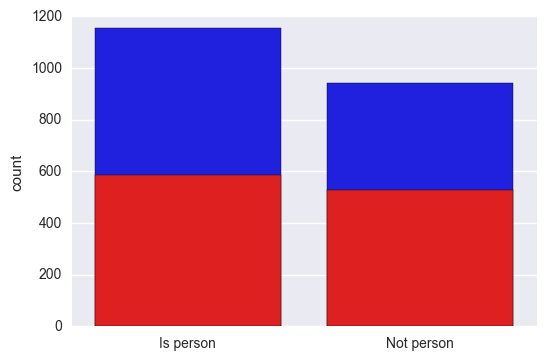

In [128]:
# Your code goes here
ax = sns.countplot(x = y_tr, color = 'blue')
ax = sns.countplot(x = y_val, color= 'r')

ax.set_xticklabels(['Is person', 'Not person'])

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

In my opinion, I will use DummyClassifier as my baseline classifier, because this classifier makes predictions using simple rules.


In [129]:
# Your code goes here
baseline=DummyClassifier()
baseline.fit(X_val,y_val)
print("the classification accuracy score for the baseline classifier is:", baseline.score(X_val,y_val))

the classification accuracy score for the baseline classifier is: 0.510332434861


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [130]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_tr,y_tr)
score_train= LR.score(X_tr,y_tr)
print ("the classification accuracy score in the training sets is:",score_train)
LR_val=LogisticRegression(solver='lbfgs')
LR_val.fit(X_val,y_val)
score_valid= LR_val.score(X_val,y_val)
print (score_valid)

the classification accuracy score in the training sets is: 0.55088389871
0.526504941599


By using Logisticregression classifier, our accuracy socre has increased because our task is a L2 problem, which is suitable for the logisticregression classifier. 

 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [131]:
np.set_printoptions(precision=3)
f5=X_tr[:,0:5]
print ("mean for the first 5 features are :",np.mean(f5,axis=0))
print ("std for the first 5 features are :", np.std(f5,axis=0))

mean for the first 5 features are : [ 0.002  0.001  0.004  0.002  0.002]
std for the first 5 features are : [ 0.001  0.001  0.004  0.001  0.002]


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [132]:
scaler=preprocessing.StandardScaler()
scaler.fit(X_tr)
x_tr_transformed=scaler.transform(X_tr)
x_val_transformed=scaler.transform(X_val)
f5_tran_tr=x_tr_transformed[:,0:5]
f5_tran_va=x_val_transformed[:,0:5]
print ("train mean for the first 5 features are :",np.mean(f5_tran_tr,axis=0))
print ("validation mean for the first 5 features are :",np.mean(f5_tran_va,axis=0))
print ("train std for the first 5 features are :",np.std(f5_tran_tr,axis=0))
print ("validation std for the first 5 features are :",np.std(f5_tran_va,axis=0))

train mean for the first 5 features are : [ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17]
validation mean for the first 5 features are : [-0.006 -0.038  0.109  0.094  0.031]
train std for the first 5 features are : [ 1.  1.  1.  1.  1.]
validation std for the first 5 features are : [ 1.013  0.97   1.049  1.057  0.975]


I think these results are kind of meet my expection, becuase the the mean values are close to 0. Furthermore, for train, the  std is 1, and for validation std is close to 1. Thus, it achieve our goal to make a standarized normal distribution,which has zero mean and unit variance.  


### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [133]:
lr_trans_tr=LogisticRegression(solver='lbfgs')
lr_trans_tr.fit(x_tr_transformed,y_tr)
print ("the classification accuracy for transformed training sets is :,",lr_trans_tr.score(x_tr_transformed,y_tr))
lr_trans_tr.fit(x_val_transformed,y_val)
print ("the classification accuracy for transformed validation sets is :,",lr_trans_tr.score(x_val_transformed,y_val))

the classification accuracy for transformed training sets is :, 0.810797897754
the classification accuracy for transformed validation sets is :, 0.939802336029



These two accuracies are much better than our baseline classifier, because we have optimized our input data sets.



### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [134]:
# Your code goes here
n=len(x_tr_transformed)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)

for train_index, test_index in kf:
    print("the number of test samples in this iteration is:",len(test_index))

the number of test samples in this iteration is: 698
the number of test samples in this iteration is: 698
the number of test samples in this iteration is: 697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [135]:
log_range = np.logspace(-5, 5, 20)
score = []


for train_index, test_index in kf:
    score_row = []
    for i in range(len(log_range)):
        lr_cross = LogisticRegression(C = log_range[i], solver='lbfgs')
        X_train_fold, X_test_fold = x_tr_transformed[train_index], x_tr_transformed[test_index]
        y_train_fold, y_test_fold = y_tr[train_index], y_tr[test_index]
        lr_cross.fit(X_train_fold, y_train_fold)
        score_row.append(lr_cross.score(X_test_fold, y_test_fold))
    score.append(score_row)
print(np.asarray(score))

[[ 0.573  0.629  0.668  0.672  0.688  0.696  0.675  0.67   0.653  0.659
   0.659  0.653  0.649  0.646  0.646  0.649  0.646  0.646  0.649  0.649]
 [ 0.546  0.632  0.695  0.719  0.729  0.735  0.702  0.675  0.655  0.636
   0.632  0.633  0.626  0.628  0.628  0.626  0.626  0.626  0.628  0.626]
 [ 0.548  0.636  0.643  0.656  0.68   0.7    0.681  0.67   0.663  0.644
   0.633  0.626  0.624  0.624  0.624  0.624  0.624  0.624  0.624  0.624]]


### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

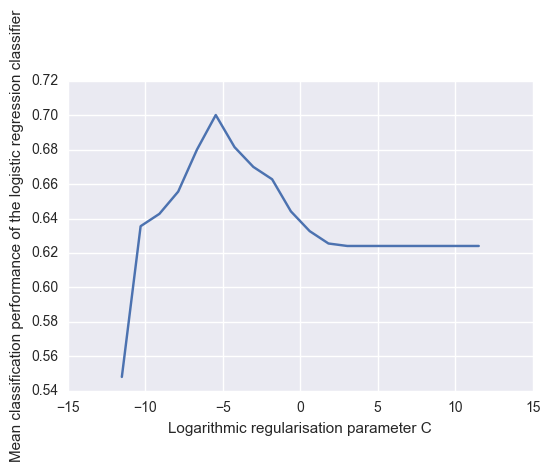

In [136]:
mean_score = np.zeros(20)

for i in range(3):
    for j in range(20):
        mean_score[j] = np.mean(score[i][j])
    
plt.plot(np.log(log_range), mean_score)

plt.xlabel('Logarithmic regularisation parameter C')
plt.ylabel('Mean classification performance of the logistic regression classifier')

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [137]:
highest_index = np.argmax(mean_score)
highest_C=log_range[highest_index]
print ("the optimal value for the regularisation parameter C of the logistic classifier is :",highest_C)
lr_highC=LogisticRegression(C=highest_C,solver='lbfgs')
lr_highC.fit(x_tr_transformed,y_tr)
print ("the classification accuracy on the validation set is:",lr_highC.score(x_val_transformed,y_val))

the optimal value for the regularisation parameter C of the logistic classifier is : 0.00428133239872
the classification accuracy on the validation set is: 0.696316262354


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [138]:
lrcv=LogisticRegressionCV(Cs=log_range,cv=kf,solver='lbfgs',refit=True)
lrcv.fit(x_tr_transformed,y_tr)
print ("the optimal value for the parameter C is :",lrcv.C_)
print ("the classification accuracy using logisticregressionCV on validation sets is:",lrcv.score(x_val_transformed,y_val))
print("yes, I can confirm my results are consistent with those from question 1.14 since they are the same")

the optimal value for the parameter C is : [ 0.004]
the classification accuracy using logisticregressionCV on validation sets is: 0.696316262354
yes, I can confirm my results are consistent with those from question 1.14 since they are the same


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [139]:
RFC=RandomForestClassifier(n_estimators=500,random_state=31)
RFC.fit(x_tr_transformed,y_tr)
print("the accuracy score on training sets is :",RFC.score(x_tr_transformed,y_tr))
print("the accuracy score on validation sets is:",RFC.score(x_val_transformed,y_val))

the accuracy score on training sets is : 1.0
the accuracy score on validation sets is: 0.700808625337


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

Although the accuracy score on tarining sets is 1, which is very high, but it also makes sense because we fitted in the training sets and used it to calculate the accuracy on the same set. 


### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [140]:
importances=RFC.feature_importances_
im_index=importances.argsort()[-50:][::-1]
x=[list_name[i] for i in im_index]
np.asarray(x)

array(['dim21', 'dim479', 'dim360', 'dim283', 'dim51', 'dim76', 'dim4',
       'dim461', 'dim330', 'dim398', 'dim343', 'dim222', 'dim274',
       'dim217', 'dim485', 'dim423', 'dim263', 'dim356', 'dim347', 'dim74',
       'dim214', 'dim500', 'dim329', 'dim92', 'dim54', 'dim326', 'dim90',
       'dim348', 'dim312', 'dim154', 'dim483', 'dim25', 'dim289', 'dim77',
       'dim134', 'dim254', 'dim427', 'dim288', 'dim73', 'dim322', 'dim440',
       'dim17', 'dim353', 'dim206', 'dim171', 'dim442', 'dim85', 'dim96',
       'dim35', 'dim48'], 
      dtype='|S6')

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [141]:
svc1 = SVC(kernel='linear').fit(x_tr_transformed, y_tr)
svc2 = SVC(kernel='rbf').fit(x_tr_transformed, y_tr)
svc3 = SVC(kernel='poly').fit(x_tr_transformed, y_tr)
print("classification accuracy on training using linear,rbf and poly:",svc1.score(x_tr_transformed,y_tr), svc2.score(x_tr_transformed,y_tr),
      svc3.score(x_tr_transformed,y_tr))
print("classification accuracy on validation using linear,rbf and poly:",svc1.score(x_val_transformed,y_val),svc2.score(x_val_transformed,y_val)
     ,svc3.score(x_val_transformed,y_val))

classification accuracy on training using linear,rbf and poly: 0.842331581462 0.910654562828 0.990922121357
classification accuracy on validation using linear,rbf and poly: 0.638814016173 0.729559748428 0.701707097934


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [142]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

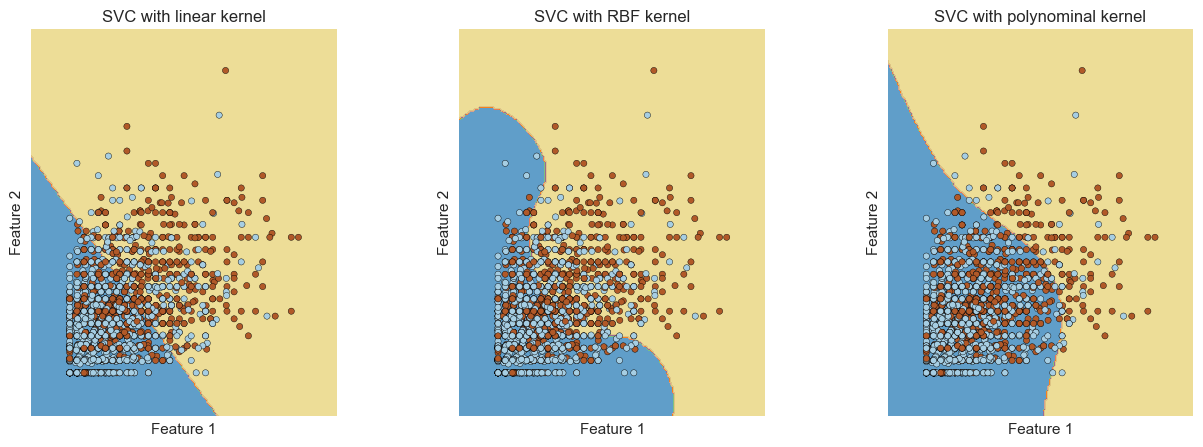

In [143]:
# Your code goes here
x_2d =x_tr_transformed [:, (20,75)]
svc_2D_1 = SVC(kernel='linear').fit(x_2d, y_tr)
svc_2D_2 = SVC(kernel='rbf').fit(x_2d, y_tr)
svc_2D_3 = SVC(kernel='poly').fit(x_2d, y_tr)
clfs = [svc_2D_1, svc_2D_2, svc_2D_3]
show_svc_decision_boundaries(clfs, x_2d, title=['SVC with linear kernel', 'SVC with RBF kernel', 'SVC with polynominal kernel'])

The RBF did the best job since it diveded the most overlap points to the left parts, and also RBF has the highest accuracy. 

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

 highest obtained mean accuracy score is : 0.715230644637
The optimal value for C:  1.6681005372
the classification score for training set is: 0.974677496417
the classification score for validation set is: 0.727762803235


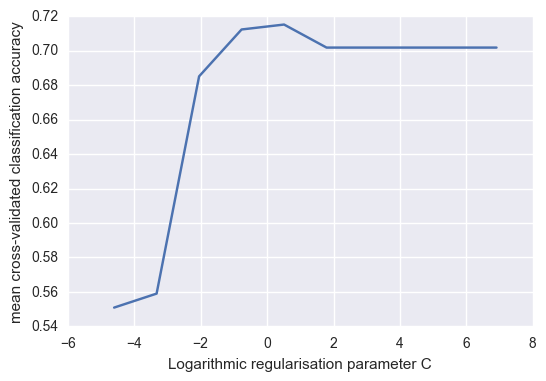

In [144]:
n=len(x_tr_transformed)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)
para_C=np.logspace(-2,3,10)
mean_score_121 = np.zeros((3,10))
i=0
for train_index, test_index in kf:
    x_train, x_test = x_tr_transformed[train_index], x_tr_transformed[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    j=0
    for C in para_C:
        svc_tune = SVC(C = C,kernel='rbf',gamma='auto')
        svc_tune.fit(X=x_train,y=y_train)
        mean_score_121[i,j]= svc_tune.score(x_test,y_test)
        j +=1
    i+=1
C_mean = np.zeros(10)
for j in range(10):
    C_mean[j] = np.mean(mean_score_121[:,j])
plt.plot(np.log(para_C), C_mean)
plt.xlabel('Logarithmic regularisation parameter C')
plt.ylabel('mean cross-validated classification accuracy')

print(" highest obtained mean accuracy score is :",max(C_mean))
highest_index_C = np.argmax(C_mean)
optimal_C = para_C[highest_index_C]
print ('The optimal value for C: ', optimal_C)
svc_121=SVC(C=optimal_C,kernel='rbf',gamma='auto')
svc_121.fit(x_tr_transformed,y_tr)
print ("the classification score for training set is:", svc_121.score(x_tr_transformed,y_tr))
print ("the classification score for validation set is:",svc_121.score(x_val_transformed,y_val))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

 highest obtained mean accuracy score is : 0.716185754475
The optimal value for gamma:  0.0016681005372
the classification score for training set is: 0.891065456283
the classification score for validation set is: 0.726864330638


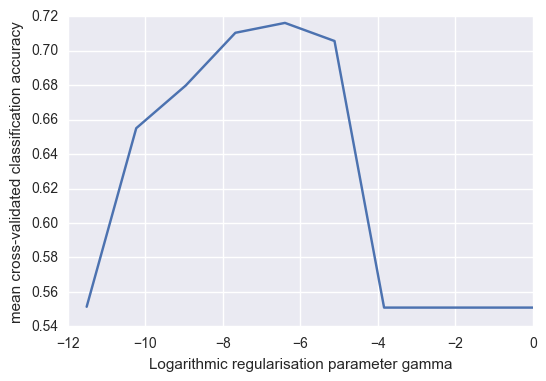

In [145]:
n=len(x_tr_transformed)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)
mean_score_122 = np.zeros((3,10))
gamma_C=np.logspace(-5,0,10)
i=0
for train_index, test_index in kf:
    x_train, x_test = x_tr_transformed[train_index], x_tr_transformed[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    j=0
    for g in gamma_C:
        svc_tune_gamma = SVC(C = 1.0,kernel='rbf',gamma=g)
        svc_tune_gamma.fit(X=x_train,y=y_train)
        mean_score_122[i,j]= svc_tune_gamma.score(x_test,y_test)
        j +=1
    i+=1
C_mean_gamma = np.zeros(10)
for j in range(10):
    C_mean_gamma[j] = np.mean(mean_score_122[:,j])
plt.plot(np.log(gamma_C), C_mean_gamma)
plt.xlabel('Logarithmic regularisation parameter gamma')
plt.ylabel('mean cross-validated classification accuracy')

print(" highest obtained mean accuracy score is :",max(C_mean_gamma))
highest_index_C_gamma = np.argmax(C_mean_gamma)
optimal_C_gamma = gamma_C[highest_index_C_gamma]
print ('The optimal value for gamma: ', optimal_C_gamma)
svc_122=SVC(C=1.0,kernel='rbf',gamma=optimal_C_gamma)
svc_122.fit(x_tr_transformed,y_tr)
print ("the classification score for training set is:", svc_122.score(x_tr_transformed,y_tr))
print ("the classification score for validation set is:",svc_122.score(x_val_transformed,y_val))

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [146]:
C_123=np.logspace(-2,1,4)
gamma_123=np.logspace(-4,-1,4)
score_grid=np.zeros((3,4,4))
n=len(x_tr_transformed)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)
i=0
for train_index, test_index in kf:
    x_train, x_test = x_tr_transformed[train_index], x_tr_transformed[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    j=0
    for g in gamma_123:
        k=0
        for C in C_123:
            svc_tune_123 = SVC(C = C,kernel='rbf',gamma=g)
            svc_tune_123.fit(X=x_train,y=y_train)
            score_grid[i,j,k]= svc_tune_123.score(x_test,y_test)
            k +=1
        j +=1
    i+=1
C_mean_123 = np.zeros((4,4))
for k in range(4):
    for j in range(4):
        C_mean_123[j,k] = np.mean(score_grid[:,k,j])

[[ 0.551  0.551  0.551  0.551]
 [ 0.551  0.683  0.551  0.551]
 [ 0.681  0.712  0.646  0.551]
 [ 0.71   0.691  0.664  0.551]]
highest obtained mean accuracy score is : 0.712362574494
the optimal value for C is : 0.1
the optimal value for gamma is : 0.01
the classification score for training set is: 0.55088389871
the classification score for validation set is: 0.526504941599


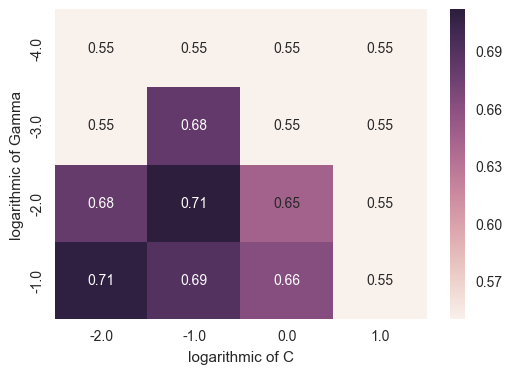

In [147]:
print (C_mean_123)
ax=sns.heatmap(C_mean_123,xticklabels=np.log10(C_123), yticklabels=np.log10(gamma_123),annot=True)
plt.xlabel('logarithmic of C')
plt.ylabel('logarithmic of Gamma')

print("highest obtained mean accuracy score is :",np.max(C_mean_123))
#index_123=np.argmax(C_mean_123)

index_123 = np.unravel_index(C_mean_123.argmax(), C_mean_123.shape)
#print(index_123)

optC_123 = C_123[index_123[1]]
optG_123 =gamma_123[index_123[0]]
print ("the optimal value for C is :" ,optC_123)
print ("the optimal value for gamma is :",optG_123)
svc_123=SVC(C=optC_123,kernel='rbf',gamma=optG_123)
svc_123.fit(x_tr_transformed,y_tr)
print ("the classification score for training set is:", svc_123.score(x_tr_transformed,y_tr))
print ("the classification score for validation set is:",svc_123.score(x_val_transformed,y_val))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

The classification accuracy on the validation set is lower than nin previous questions, because the optimal value for C and gamma we found is not the real optimal value. The way I could think of to improve the performance is increasing the num in logspace, i.e change num=4 to num =8 or larger. And another possible reason could the range we choose is a bad range, we could try choose another range for C and gamma. 

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [148]:
degree_125=np.arange(1,8)
mean_score_125=np.zeros((3,7))
i=0
for train_index, test_index in kf:
    x_train, x_test = x_tr_transformed[train_index], x_tr_transformed[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    j=0
    for d in degree_125:
        svc_tune_degree = SVC(degree=d, kernel='poly')
        svc_tune_degree.fit(X=x_train,y=y_train)
        mean_score_125[i,j]= svc_tune_degree.score(x_test,y_test)
        j +=1
    i+=1
mean_degree = np.zeros(7)
for j in range(7):
    mean_degree[j] = np.mean(mean_score_125[:,j])

the highest obtained mean accuracy score is: 0.702810105802
The optimal value for degree:  1
Classification accuracy on the training set:  0.783564261825
Classification accuracy on the validation set:  0.689128481581


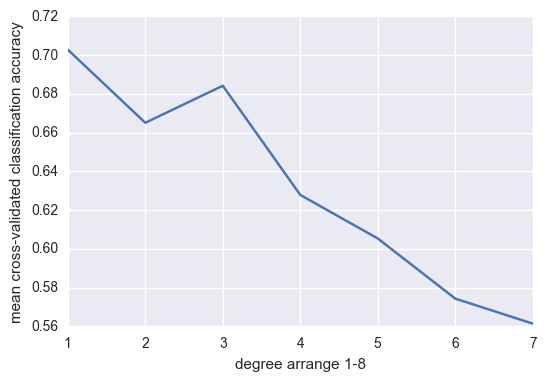

In [149]:
plt.plot(degree_125, mean_degree)
plt.xlabel('degree arrange 1-8')
plt.ylabel('mean cross-validated classification accuracy')
highest_degree_score= max(mean_degree)
print ("the highest obtained mean accuracy score is:",highest_degree_score)

max_index_degree = np.argmax(mean_degree)
opt_degree = degree_125[max_index_degree]
print ('The optimal value for degree: ', opt_degree)

svc_opt_degree = SVC(kernel='poly', degree=opt_degree).fit(x_tr_transformed, y_tr)
optd_tr_score = svc_opt_degree.score(x_tr_transformed, y_tr)
optd__val_score = svc_opt_degree.score(x_val_transformed, y_val)
print ('Classification accuracy on the training set: ', optd_tr_score)
print ('Classification accuracy on the validation set: ', optd__val_score)

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

The advantage for cross-validation is that is the dataset is limited, every fold is used for both training and validation, and for validation only once. In other words, we could see the disadvange of hold-out validation, which is when test set is very small, there will be a lot of variation. The disadvantge for cross-validation is that it will take k times much time to complete the computation. The advantage of hold-out validation is that it is normally good for residual method and takes less time to compute.
If I don't have enough samples to test, I would perfer the cross validation method. On the opposite, if I got a huge data set or it can use residual method, I would perfer hold-out method.


### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [150]:
train_A_reload = pd.read_csv(data_path_train, delimiter = ',')
valid_A_reload = pd.read_csv(data_path_valid, delimiter = ',')
x_tr_127 = train_A_reload.drop(['imgId','is_person'],axis=1)
x_val_127 = valid_A_reload.drop(['imgId','is_person'],axis=1)
y_tr_127 = train_A_reload['is_person']
y_val_127 = valid_A_reload['is_person']
scaler_127=preprocessing.StandardScaler()
scaler_127.fit(x_tr_127)
x_tr_transformed_127=scaler_127.transform(x_tr_127)
x_val_transformed_127=scaler_127.transform(x_val_127)
RFC_127 = RandomForestClassifier(criterion='entropy', n_estimators=500,random_state=31)
RFC_127.fit(x_tr_transformed_127,y_tr_127)
print ("the classification accuracy on the training set is:",RFC_127.score(x_tr_transformed_127,y_tr_127))
print ("the classification accuracy on the validation set is:", RFC_127.score(x_val_transformed_127,y_val_127))

the classification accuracy on the training set is: 1.0
the classification accuracy on the validation set is: 0.711590296496


In [151]:
#order
list_name_127=x_tr_127.columns.tolist()[0:]
importances_127=RFC_127.feature_importances_
im_index_127=importances_127.argsort()[-50:][::-1]
x_127=[list_name_127[i] for i in im_index_127]
np.asarray(x_127)

array(['is_cat', 'is_bird', 'dim21', 'dim51', 'dim360', 'dim4', 'dim76',
       'dim398', 'dim283', 'dim479', 'dim263', 'dim343', 'dim423',
       'dim485', 'dim254', 'dim461', 'dim222', 'dim356', 'dim74', 'dim288',
       'dim214', 'dim348', 'dim330', 'dim217', 'dim483', 'dim90', 'dim274',
       'dim347', 'dim17', 'dim427', 'dim35', 'dim326', 'dim73', 'dim312',
       'dim48', 'dim25', 'dim315', 'dim322', 'dim329', 'dim500', 'dim134',
       'dim206', 'is_aeroplane', 'dim96', 'dim353', 'dim442', 'dim77',
       'dim440', 'dim171', 'dim154'], 
      dtype='|S12')

I have noticed that  is_cat and is_bird become the most important two features. By looking at the images, I found that when there are cat or bird in the picture, there normally is no person.  The performance has increased compared to 1.16, and the order or 'dim' has changed. 'dim21' is still the first rank except the additional class indicator in Q1.27, but the second 'dim' rank has changed from 'dim479' to 'dim51'.
I think it would be easy to make use of the results since the accuracy score has increased, and it does make sense to me when taking pictures for some particular "object", people will normally not be present in the same picture.


## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

First, after loading the data, I found that there is no is_object(i.e:is_cat,is_bird) attributes in test dataset, so I only choose the dim1-dim500 from training and validation dataset. Then, by observing the training_B data sets, I found there are some outliers, which values are greater than 2. I think these outliers will influence the results, so I deleted these outliers, which makes my accuracy score becomes better. 
The next step is to choose the best classifier, first I tried the RandomForest classifier, and reset the n_estimators,criterion and random_state. The reason I did that is by the previous questions, I found out that with these changes, I could get a better performance. I also tried to make the n-estimators bigger, but it did not really help. In the end I got a accuracy score equals 0.7008 and logloss=0.81 by RandomForest classifier. 
Then, I tried to edit C and gamma at the same time and change the 'num' in logspace to a bigger number to see if that would help to improve the performance. Indeed, it increased the performance, the reason occured is that I could choose more values in the same range, which means the probability of picking the real optiaml values has increased. I end up with a logloss= 0.69.
Next, by looking back to the questions I have done above, I found that when I only edited the C parameter, it provided me the best result. However, it does not work for this logloss case, the reason I guess is because there is no necessarily relationships between score and logloss. I also tried to use the optimal values of C and gamma that I got from previous questions, but it did not perform better than edit C and gamma at the same time. The reason I could think of it that gamma and C will influence each other when we change them at the same time. In the end, I tried to change the value of degree, but it did not affect the performance. 
The last, I choosed the classifier that allowed me to edit the gamma and C parameters at the same time, and also change the num paramenter to a bigger value. The reason I choose this classifier is because log loss function is simply the objective function to minimize, and this classifier has the lowest logloss. 



In [3]:
data_path_partB_train = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
data_path_partB_valid = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
data_path_partB_test  = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
train_B = pd.read_csv(data_path_partB_train, delimiter = ',')
valid_B = pd.read_csv(data_path_partB_valid, delimiter = ',')
test_B  =pd.read_csv(data_path_partB_test, delimiter = ',')

dims = list(train_B.columns.values)[1:501]

features = dims + ['is_person']
train_B_new = train_B[features]
train_B_clean = train_B_new[train_B_new.apply(lambda x: x < 2).all(axis=1)]
##
x_tr_B =train_B_clean[dims].values
y_tr_B = train_B_clean['is_person'].values
x_val_B =valid_B[dims].values
y_val_B =valid_B['is_person'].values
x_test_B= test_B.drop(['is_person'],axis=1).values
##prepocessing the data 
scaler_B=preprocessing.StandardScaler()
scaler_B.fit(x_tr_B)
x_tr_transformed_B=scaler_B.transform(x_tr_B)
x_val_transformed_B=scaler_B.transform(x_val_B)
x_test_transformed_B= scaler_B.transform(x_test_B)

In [4]:
#since we tested 2 different settings for randomforst(1.16 and 1.27) and the setting blow has a higher performance
# to tune the parameter, i set the n_estimators to 1500
RFC_B = RandomForestClassifier(criterion='entropy', n_estimators=1500,random_state=31)
RFC_B.fit(x_tr_transformed_B,y_tr_B)
print("performance with Randomforest classifier.",RFC_B.score(x_val_transformed_B,y_val_B))
pred_prob_RFC=RFC_B.predict_proba(x_val_B)
print ("the log_loss is :",log_loss(y_val_B,pred_prob_RFC))

performance with Randomforest classifier. 0.700808625337
the log_loss is : 0.810387081858


In [12]:
C_B=np.logspace(-2,1,8)#increase the num to num=8
gamma_B=np.logspace(-4,-1,8)
score_grid_B=np.zeros((3,8,8))
logloss_grid_B= np.zeros((3,8,8))
n=len(x_tr_transformed_B)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)
i=0
for train_index, test_index in kf:
    x_train, x_test = x_tr_transformed_B[train_index], x_tr_transformed_B[test_index]
    y_train, y_test = y_tr_B[train_index], y_tr_B[test_index]
    j=0
    for g in gamma_B:
        k=0
        for C in C_B:
            svc_tune_B = SVC(C = C,kernel='rbf',gamma=g,probability=True)
            svc_tune_B.fit(X=x_train,y=y_train)
            score_grid_B[i,j,k]= svc_tune_B.score(x_test,y_test)
            pred_prob_B=svc_tune_B.predict_proba(x_val_B)
            logloss_grid_B[i,j,k]=log_loss(y_val_B,pred_prob_B)
            k +=1
            
        j +=1
    i+=1
C_mean_B = np.zeros((8,8))
for k in range(8):
    for j in range(8):
        C_mean_B[j,k] = np.mean(score_grid_B[:,k,j])

In [13]:
logloss_mean_B = np.zeros((8,8))
for k in range(8):
    for j in range(8):
        logloss_mean_B =np.mean(logloss_grid_B[:,k,j])

In [16]:
print("highest obtained mean accuracy score is :",np.max(C_mean_B))
index_B = np.unravel_index(C_mean_B.argmax(), C_mean_B.shape)
#print(index_123)
optC_B = C_B[index_B[1]]
optG_B =gamma_B[index_B[0]]
print ("the optimal value for C is :" ,optC_B)
print ("the optimal value for gamma is :",optG_B)
svc_B=SVC(C=optC_B,kernel='rbf',gamma=optG_B,probability=True)
svc_B.fit(x_tr_transformed_B,y_tr_B)
print ("the classification score for validation set is:",svc_B.score(x_val_B,y_val_B))
print ("the lowest logloss is:",np.min(logloss_mean_B))

highest obtained mean accuracy score is : 0.714754460034
the optimal value for C is : 0.193069772888
the optimal value for gamma is : 0.00517947467923
the classification score for validation set is: 0.473495058401
the lowest logloss is: 0.69296661167


In [18]:
# try only edit the C, since from the previous questions, the best accuracy I got is from 1.21
n=len(x_tr_transformed_B)
kf=KFold(n, n_folds=3, shuffle=True, random_state=0)
para_CB=np.logspace(-2,3,10)
mean_score_CB = np.zeros((3,10))
logloss_grid_CB=np.zeros((3,10))
i=0
for train_index, test_index in kf:
    x_train_CB, x_test_CB = x_tr_transformed_B[train_index], x_tr_transformed_B[test_index]
    y_train_CB, y_test_CB = y_tr_B[train_index], y_tr_B[test_index]
    j=0
    for C in para_CB:
        svc_tune_CB = SVC(C = C,kernel='rbf',gamma='auto',probability=True)
        svc_tune_CB.fit(X=x_train_CB,y=y_train_CB)
        mean_score_CB[i,j]= svc_tune_CB.score(x_test_CB,y_test_CB)
        pred_prob_CB=svc_tune_CB.predict_proba(x_val_B)
        logloss_grid_CB[i,j]=log_loss(y_val_B,pred_prob_CB)
        j +=1
    i+=1
C_mean_CB = np.zeros(10)
for j in range(10):
    C_mean_CB[j] = np.mean(mean_score_CB[:,j])

In [26]:
logloss_mean_CB=np.zeros(10)
for j in range(10):
    logloss_mean_CB[j]=np.mean(logloss_grid_CB[:,j])
print(" highest obtained mean accuracy score is :",max(C_mean_CB))
highest_index_CB = np.argmax(C_mean_CB)
optimal_CB = para_CB[highest_index_CB]
print ('The optimal value for C: ', optimal_CB)
svc_CB=SVC(C=optimal_CB,kernel='rbf',gamma='auto',probability=True)
svc_CB.fit(x_tr_transformed_B,y_tr_B)
print ("the classification score for validation set is:",svc_CB.score(x_val_transformed_B,y_val_B))
print ("the log_loss is :",np.min(logloss_mean_CB))

 highest obtained mean accuracy score is : 0.715230644637
The optimal value for C:  1.6681005372
the classification score for validation set is: 0.727762803235
the log_loss is : 0.857592925742


In [20]:
## try using the best gamma value and C value
# C=1.668100  gamma=0.001668
svc_C_G=SVC(C=1.6681005372,kernel='rbf',gamma=0.0016681005372,probability=True)
svc_C_G.fit(x_tr_transformed_B,y_tr_B)
print ("classofication score for valdatopmset is:",svc_C_G.score(x_val_transformed_B,y_val_B))
pred_prob_bestCG = svc_C_G.predict_proba(x_val_B)
print ("the log_loss is:",log_loss(y_val_B,pred_prob_bestCG))

classofication score for valdatopmset is: 0.725965858041
the log_loss is: 0.825039570778


In [23]:
## try changing  degree.
svc_D_G=SVC(C=1.6681005372,kernel='rbf',gamma=0.0016681005372,degree=1,probability=True)
svc_D_G.fit(x_tr_transformed_B,y_tr_B)
print ("classification score:",svc_D_G.score(x_val_transformed_B,y_val_B))
pred_prob_degree = svc_D_G.predict_proba(x_val_B)
print ("the logloss is :",log_loss(y_val_B,pred_prob_degree))

classification score: 0.725965858041
the logloss is : 0.835895013439


In [29]:
# the best is editing gamma and C at the same time and change num to a higher number 8.......
pred_proba=svc_B.predict_proba(x_test_B)

In [30]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

*Your answer goes here*

